<a href="https://colab.research.google.com/github/blparish/Confluence-Test--Training-Evaluation/blob/main/Run_Cellpose_metrics__and_head_to_head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose) |
[data set](https://www.cellpose.org/dataset)

This notebook shows how to process 2D or 3D images, including those shared with the Cellpose data set, saved on Google Drive.

This notebook is adapted from the notebook by Pachitariu, M., Rariden, M., & Stringer, C. (2025)inspired by the [Cellpose notebook series](https://github.com/MouseLand/cellpose).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


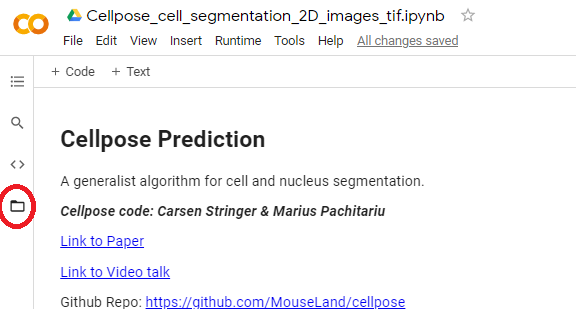

Check GPU and instantiate model - will download weights.

In [ ]:
from pathlib import Path
import numpy as np
import warnings
import imageio.v2 as imageio
import torch
from skimage.color import label2rgb
from cellpose import models, utils, io

# configuration
model_name = "cyto"                                        # change to alternative models as desired
test_dir   = Path("/content/drive/test")                     # change to desired path
save_dir   = Path(f"/content/drive/test_preds_{model_name}")
save_dir.mkdir(parents=True, exist_ok=True)
use_gpu    = torch.cuda.is_available()                     # updated check

# load model
print("GPU available:", use_gpu)
cp = models.Cellpose(model_type=model_name, gpu=use_gpu)

# iterate over images
image_files = sorted(test_dir.glob("*_img.png"))
print(f"Found {len(image_files)} images; outputs will be written to {save_dir}")

for img_path in image_files:
    try:
        img = imageio.imread(img_path).astype(np.float32)

        # sanity checks
        if img.max() <= img.min():
            print(f"Skipping {img_path.name}: zero dynamic range")
            continue
        if np.var(img) < 1e-6:
            print(f"Skipping {img_path.name}: near-zero variance")
            continue

        # normalise to 0-1
        img = (img - img.min()) / (img.max() - img.min())

        # run Cellpose
        masks = models.Cellpose.eval(cp, img, diameter=None, channels=[0, 0])[0]

        # save mask
        mask_name = img_path.stem.replace("_img", f"_{model_name}_masks.png")
        io.imsave(str(save_dir / mask_name), masks.astype(np.uint16))

        # save overlay
        outlines = utils.masks_to_outlines(masks)
        overlay  = label2rgb(outlines, image=img, bg_label=0)
        ol_name  = img_path.stem.replace("_img", f"_{model_name}_overlay.png")
        io.imsave(str(save_dir / ol_name), (overlay * 255).astype(np.uint8))

        print(f"Processed {img_path.name}  →  {mask_name}")

    except Exception as err:
        print(f"Error with {img_path.name}: {err}")


model evaluation

In [ ]:
# evaluate_masks.py
# Evaluate Cellpose predictions (IoU, Dice, ROI counts)

from pathlib import Path
import numpy as np
import pandas as pd
import skimage.io as skio
from skimage.measure import label
from tqdm import tqdm

#  metric helpers
def iou(gt, pr):
    inter = np.logical_and(gt, pr).sum()
    union = np.logical_or(gt, pr).sum()
    return inter / union if union else 0.0

def dice(gt, pr):
    inter = np.logical_and(gt, pr).sum()
    denom = gt.sum() + pr.sum()
    return 2.0 * inter / denom if denom else 0.0

# folders and naming
gt_dir   = Path("/content/drive/MyDrive/test")          # change path to ground truth
pred_dir = Path("/content/drive/MyDrive/test_preds_cyto")  # change folder here for predictions

model_name = pred_dir.name.replace("test_preds_", "")          # e.g. “cyto”
suffix     = f"_{model_name}_masks.png"                        # prediction file suffix

#  file lists
gt_files   = {p.stem.replace("_masks", ""): p for p in gt_dir.glob("*_masks.png")}
pred_files = sorted(p for p in pred_dir.iterdir() if p.name.endswith(suffix))

if not pred_files:
    raise RuntimeError(f"No prediction files ending with {suffix} found in {pred_dir}")

#  main evaluation
records = []

for p_pred in tqdm(pred_files, desc=f"Evaluating {model_name}"):
    key = p_pred.stem.replace(suffix[:-4], "")                 # remove “_{model}_masks”
    p_gt = gt_files.get(key)

    if p_gt is None:
        print(f"Ground-truth mask missing for image id: {key}")
        continue

    gt  = skio.imread(p_gt)   > 0
    pr  = skio.imread(p_pred) > 0

    records.append({
        "Image"    : key,
        "GT_ROIs"  : label(gt).max(),
        "Pred_ROIs": label(pr).max(),
        "IoU"      : iou(gt, pr),
        "Dice"     : dice(gt, pr),
    })

#  save / report
df = pd.DataFrame(records).sort_values("Image")
out_csv = pred_dir / f"{model_name}_eval_summary.csv"
df.to_csv(out_csv, index=False)

print(f"Processed {len(df)} images")
print(df[["IoU","Dice"]].describe().round(3))
print(f"CSV written to: {out_csv}")


Evaluating cyto: 100%|██████████| 68/68 [00:00<00:00, 68.33it/s]

Processed 68 images
          IoU    Dice
count  68.000  68.000
mean    0.772   0.861
std     0.156   0.115
min     0.259   0.412
25%     0.655   0.792
50%     0.811   0.895
75%     0.890   0.942
max     0.974   0.987
CSV written to: /content/drive/MyDrive/GWU/Praxis/Images/test_preds_cyto/cyto_eval_summary.csv


Run alternative models

In [ ]:
# Run predictions with Cellpose-2 models: cyto2 and nuclei
import numpy as np
from pathlib import Path
from cellpose import models, io, utils
from skimage.color import label2rgb
import imageio, warnings, os

warnings.filterwarnings('ignore')
io.imread = imageio.imread            # avoid cv2 conflicts

test_dir   = Path("/content/drive/MyDrive/test")  # update to desired path
image_list = sorted(test_dir.glob("*_img.png"))

model_names = ["cyto2", "nuclei"]     # cyto removed

for name in model_names:
    print(f"\n Running predictions for {name}")
    cp      = models.Cellpose(model_type=name, gpu=True)   # Cellpose-2 API
    out_dir = Path(f"/content/drive/MyDrive/GWU/Praxis/Images/test_preds_{name}")
    out_dir.mkdir(parents=True, exist_ok=True)

    for img_path in image_list:
        try:
            # load & normalise
            img = io.imread(str(img_path)).astype(np.float32)
            mn, mx = img.min(), img.max()
            img = (img - mn) / (mx - mn) if mx > mn else img
            if img.var() < 1e-6:
                print(f"Skipping {img_path.name} (near-zero variance)")
                continue

            #run model
            masks, flows, styles, diams = cp.eval(img,
                                                  channels=[0, 0],
                                                  diameter=None)

            #save mask
            mask_name = img_path.stem.replace("_img", f"_{name}_masks.png")
            io.imsave(str(out_dir / mask_name), masks.astype(np.uint16))

            # save overlay
            outlines   = utils.masks_to_outlines(masks)
            overlay    = label2rgb(outlines, image=img, bg_label=0)
            overlay_nm = img_path.stem.replace("_img", f"_{name}_overlay.png")
            io.imsave(str(out_dir / overlay_nm), (overlay * 255).astype(np.uint8))

            print(f"Processed {img_path.name}  →  {mask_name}")
        except Exception as e:
            print(f"Error on {img_path.name}: {e}")



--- Running predictions for cyto2 ---
Processed 000_img.png  →  000_cyto2_masks.png
Processed 001_img.png  →  001_cyto2_masks.png
Processed 002_img.png  →  002_cyto2_masks.png
Processed 003_img.png  →  003_cyto2_masks.png
Processed 004_img.png  →  004_cyto2_masks.png
Processed 005_img.png  →  005_cyto2_masks.png
Processed 006_img.png  →  006_cyto2_masks.png
Processed 007_img.png  →  007_cyto2_masks.png
Processed 008_img.png  →  008_cyto2_masks.png
Processed 009_img.png  →  009_cyto2_masks.png
Processed 010_img.png  →  010_cyto2_masks.png
Processed 011_img.png  →  011_cyto2_masks.png
Processed 012_img.png  →  012_cyto2_masks.png
Processed 013_img.png  →  013_cyto2_masks.png
Processed 014_img.png  →  014_cyto2_masks.png
Processed 015_img.png  →  015_cyto2_masks.png
Processed 016_img.png  →  016_cyto2_masks.png
Processed 017_img.png  →  017_cyto2_masks.png
Processed 018_img.png  →  018_cyto2_masks.png
Processed 019_img.png  →  019_cyto2_masks.png
Processed 020_img.png  →  020_cyto2_masks

Visualization of model performance

Evaluate confluence/ Total number of cells

Model accuracy

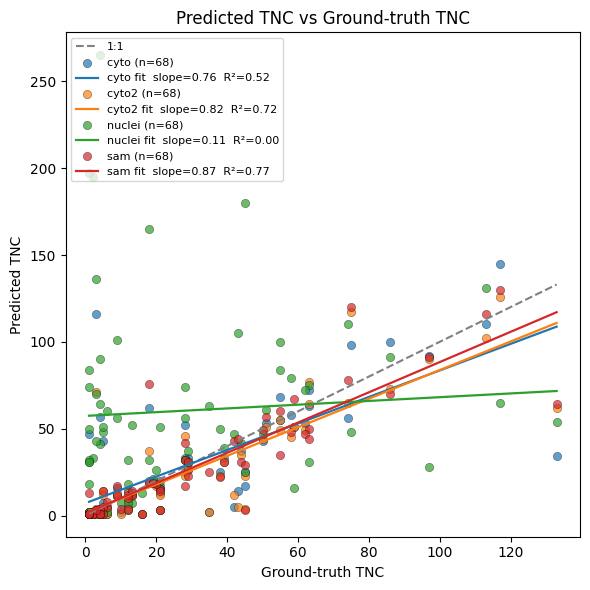

saved /content/drive/MyDrive/GWU/Praxis/Figures/tnc_regressions.png


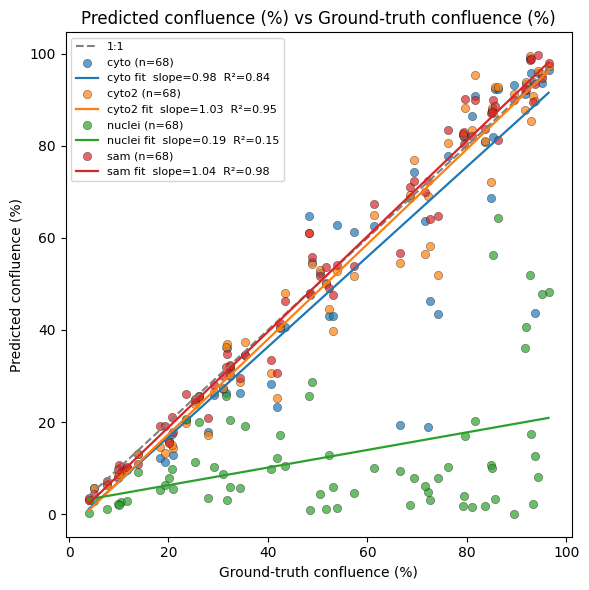

saved /content/drive/MyDrive/GWU/Praxis/Figures/conf_regressions.png


In [ ]:
import os, sys, warnings, math
os.environ["NUMBA_DISABLE_JIT"] = "1"
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, skimage.io as skio, skimage.measure as skm

gt_dir  = Path("/content/drive/MyDrive/test")
root    = Path("/content/drive/MyDrive/Images")
fig_dir = Path("/content/drive/MyDrive/Figures"); fig_dir.mkdir(exist_ok=True)

pred_specs = {
    "cyto"   : (root / "test_preds_cyto",    lambda i: f"{i}_cyto_masks.png"),
    "cyto2"  : (root / "test_preds_cyto2",   lambda i: f"{i}_cyto2_masks.png"),
    "nuclei" : (root / "test_preds_nuclei",  lambda i: f"{i}_nuclei_masks.png"),
    "sam"    : (root / "test_preds_sam",     lambda i: f"{i}_img_SAMmasks.png"),
}

sam_fallback = root / "archive/test(archive)"
if not (pred_specs["sam"][0]).exists() and sam_fallback.exists():
    pred_specs["sam"] = (sam_fallback, pred_specs["sam"][1])

gt_files = sorted(gt_dir.glob("*_masks.png"))
if not gt_files:
    sys.exit("no ground-truth masks found")

roi_count   = lambda m: skm.label(m).max()
confluence  = lambda m: 100.0 * m.mean()
palette     = {"cyto":"#1f77b4","cyto2":"#ff7f0e","nuclei":"#2ca02c","sam":"#d62728"}

records = []
for model, (pdir, name_fn) in pred_specs.items():
    if not pdir.exists():
        print(f"skip {model}: {pdir} absent"); continue
    found = False
    for gt_p in gt_files:
        idx   = gt_p.stem.replace("_masks","")
        pr_p  = pdir / name_fn(idx)
        if not pr_p.exists(): continue
        found = True
        gt = skio.imread(gt_p)  > 0
        pr = skio.imread(pr_p)  > 0
        records.append({
            "Model":model,
            "GT_ROIs":roi_count(gt),"Pred_ROIs":roi_count(pr),
            "GT_Conf":confluence(gt),"Pred_Conf":confluence(pr)
        })
    if not found: print(f"skip {model}: no predictions found")

if not records:
    sys.exit("no predictions for any model")

df = pd.DataFrame(records)

def lin_reg(x,y):
    if x.size < 2: return math.nan, math.nan, math.nan
    m,b = np.polyfit(x,y,1)
    r2  = 1 - np.sum((y-(m*x+b))**2)/np.sum((y-y.mean())**2)
    return m,b,r2

def plot_reg(metric_gt, metric_pr, xlabel, ylabel, out_name):
    plt.figure(figsize=(6,6))
    xmin, xmax = df[metric_gt].min(), df[metric_gt].max()
    plt.plot([xmin, xmax], [xmin, xmax], "--", color="gray", label="1:1")
    for model, g in df.groupby("Model"):
        x, y = g[metric_gt].values, g[metric_pr].values
        m,b,r2 = lin_reg(x,y)
        c = palette.get(model)
        plt.scatter(x,y,label=f"{model} (n={len(x)})",color=c,alpha=.7,edgecolor="k",linewidth=.3)
        if not math.isnan(m):
            xs = np.linspace(xmin, xmax, 100)
            plt.plot(xs, m*xs+b, color=c, lw=1.6,
                     label=f"{model} fit  slope={m:.2f}  R²={r2:.02f}")
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs {xlabel}")
    plt.legend(fontsize=8, loc="upper left")
    plt.tight_layout()
    out_path = fig_dir / out_name
    plt.savefig(out_path, dpi=300)
    plt.show()
    print("saved", out_path)

plot_reg("GT_ROIs","Pred_ROIs","Ground-truth TNC","Predicted TNC","tnc_regressions.png")
plot_reg("GT_Conf","Pred_Conf","Ground-truth confluence (%)","Predicted confluence (%)","conf_regressions.png")

Appendix Figures

In [ ]:
import os, warnings, sys, math
os.environ["NUMBA_DISABLE_JIT"] = "1"
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np, pandas as pd
import skimage.io as skio, skimage.measure as skm


#  CONFIG

gt_dir  = Path("/content/gdrive/MyDrive/Images/test")
root    = Path("/content/gdrive/MyDrive/Images")

pred_specs = {
    "cyto"  : (root/"test_preds_cyto",    lambda i: f"{i}_cyto_masks.png"),
    "cyto2" : (root/"test_preds_cyto2",   lambda i: f"{i}_cyto2_masks.png"),
    "nuclei": (root/"test_preds_nuclei",  lambda i: f"{i}_nuclei_masks.png"),
    "sam"   : (root/"test_preds_sam",     lambda i: f"{i}_SAM_masks.png"),
}

# KPIs
roi_count  = lambda mask: skm.label(mask).max()
confluence = lambda mask: 100.0 * mask.mean()

# Processing
for model, (pdir, name_fn) in pred_specs.items():
    eval_csv = pdir/f"{model}_eval_summary.csv"
    if not pdir.exists():
        print(f"skip {model}: prediction folder not found")
        continue

    if eval_csv.exists():
        df_old = pd.read_csv(eval_csv)
        df_old['Image'] = df_old['Image'].astype(str)
    else:
        df_old = pd.DataFrame({"Image":[]})

    # recompute per-image metrics
    rows = []
    for gt_p in sorted(gt_dir.glob("*_masks.png")):
        img_id = gt_p.stem.replace("_masks","")
        pr_p   = pdir/name_fn(img_id)
        if not pr_p.exists():
            continue

        gt_mask = skio.imread(gt_p)>0
        pr_mask = skio.imread(pr_p)>0

        rows.append({
            "Image"     : img_id,
            "GT_ROIs"   : roi_count(gt_mask),
            "Pred_ROIs" : roi_count(pr_mask),
            "GT_Conf"   : confluence(gt_mask),
            "Pred_Conf" : confluence(pr_mask),
        })

    if not rows:
        print(f"skip {model}: no valid predictions found")
        continue

    df_new = pd.DataFrame(rows)
    df_new['Image'] = df_new['Image'].astype(str)
    df_merged = pd.merge(
        df_new,
        df_old,
        on="Image",
        how="left",
        suffixes=("", "_old")
    )

    for c in ("GT_ROIs_old","Pred_ROIs_old","GT_Conf_old","Pred_Conf_old"):
        if c in df_merged.columns:
            df_merged.drop(columns=[c], inplace=True)

    df_merged.to_csv(eval_csv, index=False)
    print(f"updated {eval_csv} with GT_ROIs,Pred_ROIs,GT_Conf,Pred_Conf")

updated /content/gdrive/MyDrive/GWU/Praxis/Images/test_preds_cyto/cyto_eval_summary.csv with GT_ROIs,Pred_ROIs,GT_Conf,Pred_Conf
updated /content/gdrive/MyDrive/GWU/Praxis/Images/test_preds_cyto2/cyto2_eval_summary.csv with GT_ROIs,Pred_ROIs,GT_Conf,Pred_Conf
updated /content/gdrive/MyDrive/GWU/Praxis/Images/test_preds_nuclei/nuclei_eval_summary.csv with GT_ROIs,Pred_ROIs,GT_Conf,Pred_Conf
updated /content/gdrive/MyDrive/GWU/Praxis/Images/archive/test(archive)/sam_eval_summary.csv with GT_ROIs,Pred_ROIs,GT_Conf,Pred_Conf


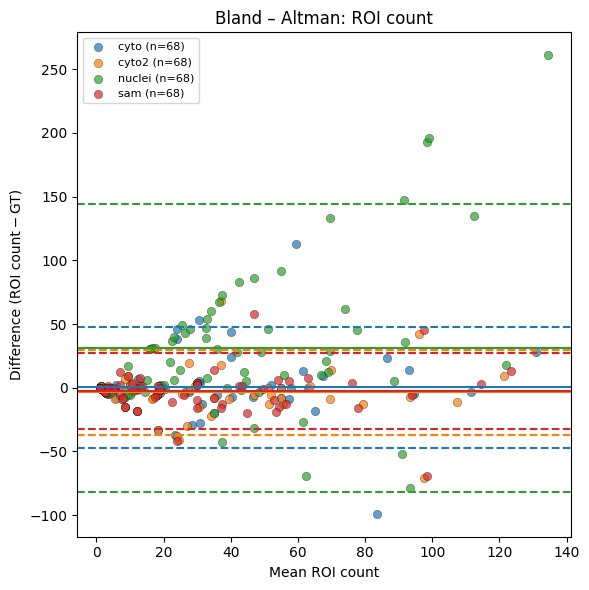

saved /content/drive/MyDrive/GWU/Praxis/Figures/ba_roi.png


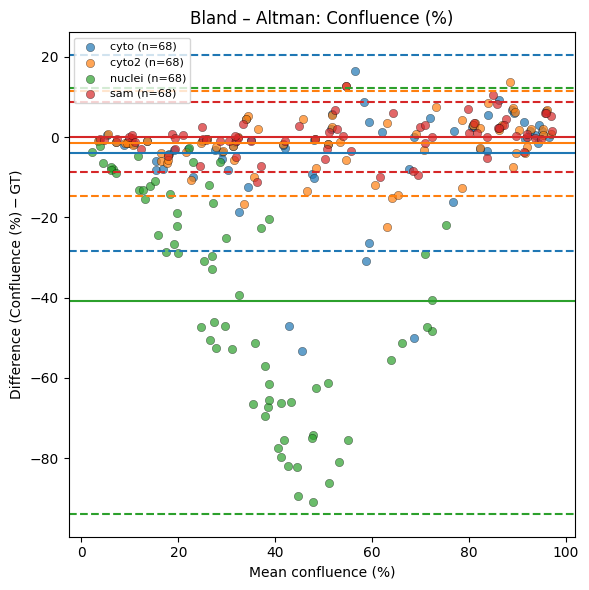

saved /content/drive/MyDrive/GWU/Praxis/Figures/ba_confluence.png


In [ ]:
def bland_altman_plot(metric_gt, metric_pr, xlabel, ylabel, out_name):
    plt.figure(figsize=(6,6))
    for model, group in df.groupby("Model"):
        mean_vals = (group[metric_gt] + group[metric_pr]) / 2
        diff_vals = group[metric_pr] - group[metric_gt]
        bias = diff_vals.mean()
        sd   = diff_vals.std()
        # scatter
        plt.scatter(mean_vals, diff_vals,
                    label=f"{model} (n={len(diff_vals)})",
                    color=palette[model], alpha=0.7, edgecolor="k", linewidth=0.3)
        # bias and limits
        plt.axhline(bias,               color=palette[model], linestyle="-")
        plt.axhline(bias + 1.96*sd,     color=palette[model], linestyle="--")
        plt.axhline(bias - 1.96*sd,     color=palette[model], linestyle="--")
    plt.xlabel(xlabel)
    plt.ylabel(f"Difference ({ylabel} − GT)")
    plt.title(f"Bland – Altman: {ylabel}")
    plt.legend(fontsize=8, loc="upper left")
    plt.tight_layout()
    out_path = fig_dir / out_name
    plt.savefig(out_path, dpi=300)
    plt.show()
    print("saved", out_path)

bland_altman_plot(
    metric_gt="GT_ROIs", metric_pr="Pred_ROIs",
    xlabel="Mean ROI count", ylabel="ROI count",
    out_name="ba_roi.png"
)

bland_altman_plot(
    metric_gt="GT_Conf", metric_pr="Pred_Conf",
    xlabel="Mean confluence (%)", ylabel="Confluence (%)",
    out_name="ba_confluence.png"
)


In [ ]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import numpy as np

# convert p-values → stars
def p_to_stars(p):
    if p <= 1e-4:
        return "****"
    elif p <= 1e-3:
        return "***"
    elif p <= 1e-2:
        return "**"
    elif p <= 5e-2:
        return "*"
    else:
        return "ns"

# paths
root     = Path("/content/gdrive/MyDrive/Images")
fig_root = Path("/content/gdrive/MyDrive/Figures")
fig_root.mkdir(parents=True, exist_ok=True)

# gather all *_eval_summary.csv
csvs = list(root.rglob("*_eval_summary.csv"))
if not csvs:
    raise RuntimeError("No *_eval_summary.csv found – run your evaluation script first.")

# load only those with Model, Dice, IoU
dfs = []
for p in csvs:
    df = pd.read_csv(p)
    if {"Model","Dice","IoU"}.issubset(df.columns):
        dfs.append(df[["Model","Dice","IoU"]])
    else:
        print(f"Skipping {p.name}: missing Model/Dice/IoU")

if not dfs:
    raise RuntimeError("No valid summaries containing Model + Dice + IoU.")

df_all = pd.concat(dfs, ignore_index=True)

# seaborn
melt = df_all.melt(
    id_vars    = ["Model"],
    value_vars = ["Dice","IoU"],
    var_name   = "Score",
    value_name = "Value"
)

# draw split‐violin
plt.figure(figsize=(8,5))
ax = sns.violinplot(
    data    = melt,
    x       = "Model",
    y       = "Value",
    hue     = "Score",
    split   = True,
    inner   = "quartile",
    palette = {"Dice":"tab:blue","IoU":"tab:orange"}
)
# raise the ceiling to 1.35 so the brackets fit fully inside
ax.set(ylim=(0, 1.35), xlabel="", ylabel="Score")
plt.title("Dice & IoU Distributions per Model")
plt.legend(title="")

# Wilcoxon SAM vs each on Dice → draw brackets + stars
models = sorted(df_all["Model"].unique())
if "sam" not in models:
    raise RuntimeError("SAM not found among models.")

y_start = 1.10
y_step  = 0.07
dh      = 0.02

for m in models:
    if m == "sam":
        continue
    # indices for plotting
    i1 = models.index(m)
    i2 = models.index("sam")
    a  = df_all.loc[df_all.Model==m,   "Dice"].values
    b  = df_all.loc[df_all.Model=="sam","Dice"].values
    W,p = wilcoxon(b, a)  # paired: sam vs models
    star = p_to_stars(p)

    # draw the little bracket
    ax.plot([i1, i1, i2, i2],
            [y_start, y_start+dh, y_start+dh, y_start],
            lw=1.2, c="k")
    ax.text((i1+i2)/2, y_start+dh+0.005,
            star, ha="center", va="bottom", color="k", fontsize=10)
    y_start += y_step

# footnote
plt.figtext(
    0.5, -0.05,
    "Brackets: paired Wilcoxon signed-rank on Dice; **** p ≤ 1×10⁻⁴, *** p ≤ 10⁻³, ** p ≤ 10⁻², * p ≤ 0.05, ns otherwise",
    ha="center", fontsize=9
)

# save
plt.tight_layout()
out = fig_root/"dice_iou_violin_with_stars.png"
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.close()
print(" Saved to", out)

from scipy.stats import bartlett, levene

# list of model names in the order you want to compare
models = ["cyto","cyto2","nuclei","sam"]

# collect per‐model arrays
dice_groups = [ df_all.loc[df_all.Model==m, "Dice"].values for m in models ]
iou_groups  = [ df_all.loc[df_all.Model==m,  "IoU" ].values for m in models ]

print("=== Variance equality tests across all 4 models ===\n")

# Bartlett’s test (assumes normality)
stat_d, p_d = bartlett(*dice_groups)
stat_i, p_i = bartlett(*iou_groups)
print(f"Bartlett’s test on Dice variances:    χ²={stat_d:.2f}, p={p_d:.3g}")
print(f"Bartlett’s test on IoU   variances:    χ²={stat_i:.2f}, p={p_i:.3g}\n")

# Levene’s test (robust to departures from normality)
stat_d, p_d = levene(*dice_groups, center="median")
stat_i, p_i = levene(*iou_groups,  center="median")
print(f"Levene’s  test on Dice variances:    W={stat_d:.2f}, p={p_d:.3g}")
print(f"Levene’s  test on IoU   variances:    W={stat_i:.2f}, p={p_i:.3g}")

from itertools import combinations
from scipy.stats import levene

models = ["cyto","cyto2","nuclei","sam"]
groups = { m: df_all.loc[df_all.Model==m, "Dice"].values for m in models }

print("\n=== Pairwise Levene’s tests on Dice variances ===")
alpha = 0.05 / (len(models)*(len(models)-1)/2)  # simple Bonferroni
for m1, m2 in combinations(models, 2):
    stat, p = levene(groups[m1], groups[m2], center="median")
    signif = "YES" if p < alpha else "no"
    print(f"{m1:6s} vs {m2:6s} : W={stat:.2f}, p={p:.3g}  variance diff? {signif}")

print(f"\n(Note: Bonferroni‐corrected α = {alpha:.3g})")


 Saved to /content/gdrive/MyDrive/GWU/Praxis/Figures/dice_iou_violin_with_stars.png
=== Variance equality tests across all 4 models ===

Bartlett’s test on Dice variances:    χ²=180.59, p=6.59e-39
Bartlett’s test on IoU   variances:    χ²=54.30, p=9.7e-12

Levene’s  test on Dice variances:    W=55.34, p=7.14e-28
Levene’s  test on IoU   variances:    W=13.34, p=3.83e-08

=== Pairwise Levene’s tests on Dice variances ===
cyto   vs cyto2  : W=4.04, p=0.0464  variance diff? no
cyto   vs nuclei : W=46.96, p=2.39e-10  variance diff? YES
cyto   vs sam    : W=9.53, p=0.00246  variance diff? YES
cyto2  vs nuclei : W=80.96, p=1.96e-15  variance diff? YES
cyto2  vs sam    : W=2.35, p=0.128  variance diff? no
nuclei vs sam    : W=95.56, p=2.29e-17  variance diff? YES

(Note: Bonferroni‐corrected α = 0.00833)


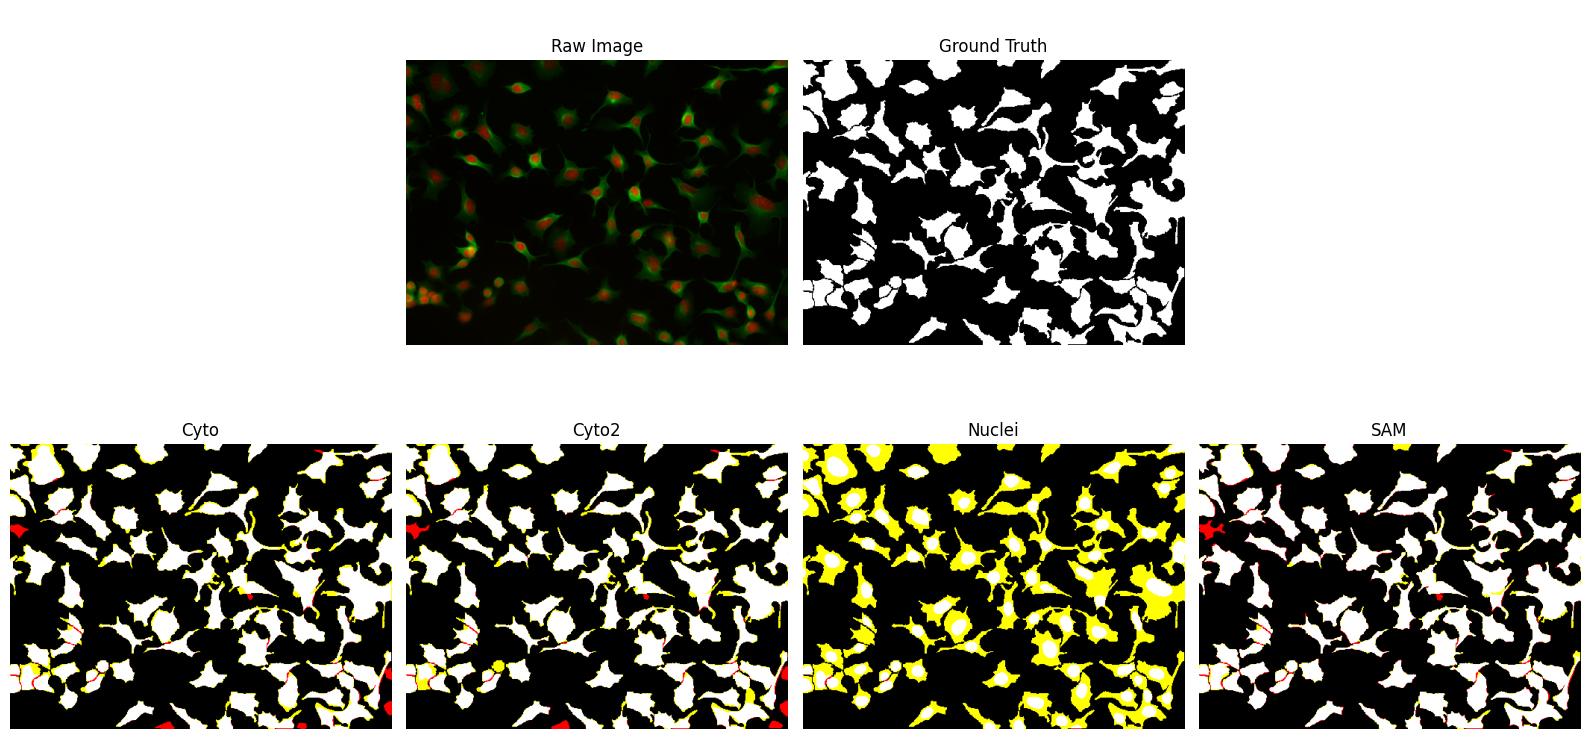

Saved to /content/gdrive/MyDrive/GWU/Praxis/Figures/000_model_error_overlay.png


In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io

base_dir = Path("/content/gdrive/MyDrive/Images")
test_dir = base_dir / "test"
fig_dir  = Path("/content/gdrive/MyDrive/Figures")

pred_folders = {
    "Cyto": base_dir / "test_preds_cyto",
    "Cyto2": base_dir / "test_preds_cyto2",
    "Nuclei": base_dir / "test_preds_nuclei",
    "SAM": base_dir / "test_preds_sam",
}
alt = base_dir / "archive" / "test(archive)"
if not pred_folders["SAM"].exists() and alt.exists():
    pred_folders["SAM"] = alt

fn = {
    "raw":    "{idx}_img.png",
    "gt":     "{idx}_masks.png",
    "Cyto":  "{idx}_cyto_masks.png",
    "Cyto2":"{idx}_cyto2_masks.png",
    "Nuclei": "{idx}_nuclei_masks.png",
    "SAM":    "{idx}_img_SAMmasks.png"
}

# pick one
imgs = sorted(test_dir.glob("*_img.png"))
idx  = imgs[0].stem.replace("_img","")
raw  = io.imread(test_dir / fn["raw"].format(idx=idx))
gt   = io.imread(test_dir / fn["gt"].format(idx=idx)) > 0

# build 2×4 grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
# top row: blank, raw, gt, blank
for ax in (axes[0,0], axes[0,3]):
    ax.axis("off")
axes[0,1].imshow(raw);   axes[0,1].set_title("Raw Image");   axes[0,1].axis("off")
axes[0,2].imshow(gt, cmap="gray"); axes[0,2].set_title("Ground Truth"); axes[0,2].axis("off")

# bottom row: four model‐error overlays
roi_count  = lambda m: (m>0).astype(int)
palette    = {"Cyto":"#1f77b4","Cyto2":"#ff7f0e","Nuclei":"#2ca02c","SAM":"#d62728"}
for i,(model, folder) in enumerate(pred_folders.items()):
    ax = axes[1, i]
    p = folder / fn[model].format(idx=idx)
    pred = (io.imread(p)>0) if p.exists() else np.zeros_like(gt)

    tp = gt & pred
    fn_ = gt & ~pred
    fp = ~gt & pred

    overlay = np.zeros((*gt.shape,3), dtype=np.uint8)
    overlay[tp]  = [255,255,255]
    overlay[fn_] = [255,255,  0]
    overlay[fp]  = [255,  0,  0]

    ax.imshow(overlay)
    ax.set_title(model)
    ax.axis("off")

plt.tight_layout()
out = fig_dir / f"{idx}_model_error_overlay.png"
plt.savefig(out, dpi=300)
plt.show()
print("Saved to", out)


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# point to your per‐image CSVs
IMG_ROOT = Path("/content/gdrive/MyDrive/Images")
MODEL_CSV = {
    "cyto"  : IMG_ROOT/"test_preds_cyto"/"cyto_eval_summary.csv",
    "cyto2" : IMG_ROOT/"test_preds_cyto2"/"cyto2_eval_summary.csv",
    "nuclei": IMG_ROOT/"test_preds_nuclei"/"nuclei_eval_summary.csv",
    "sam"   : IMG_ROOT/"test_preds_sam"/"sam_eval_summary.csv",
}

#  load each one, compute mean±std for the five metrics
records = []
for model, path in MODEL_CSV.items():
    if not path.exists():
        print(f"Skipping {model!r}: {path} not found")
        continue
    df = pd.read_csv(path)
    want = ["Dice","IoU","AJI","AP50","AP75"]
    missing = [w for w in want if w not in df.columns]
    if missing:
        print(f"Skipping {model!r}: missing columns {missing}")
        continue

    stats = {}
    for m in want:
        stats[m] = f"{df[m].mean():.3f} ± {df[m].std():.3f}"

    records.append({
        "Model": model,
        **stats
    })

if not records:
    raise RuntimeError("No valid per‐image CSVs found with AP75 in them.")

# assemble into a DataFrame and write out
out_df = pd.DataFrame(records).set_index("Model")
FIG_DIR = Path("/content/gdrive/MyDrive/Figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR/"segmentation_summary_with_AP75.csv"
out_df.to_csv(out_path)

print("Wrote:", out_path)
print(out_df)


Wrote: /content/gdrive/MyDrive/GWU/Praxis/Figures/segmentation_summary_with_AP75.csv
                 Dice            IoU            AJI           AP50  \
Model                                                                
cyto    0.861 ± 0.115  0.772 ± 0.156  0.672 ± 0.166  0.745 ± 0.202   
cyto2   0.889 ± 0.072  0.808 ± 0.110  0.695 ± 0.145  0.773 ± 0.151   
nuclei  0.351 ± 0.260  0.246 ± 0.217  0.216 ± 0.203  0.171 ± 0.232   
sam     0.918 ± 0.060  0.854 ± 0.096  0.784 ± 0.113  0.855 ± 0.124   

                 AP75  
Model                  
cyto    0.503 ± 0.244  
cyto2   0.532 ± 0.220  
nuclei  0.061 ± 0.115  
sam     0.631 ± 0.245  


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from scipy.stats import wilcoxon

root = Path("/content/gdrive/MyDrive/Images")
csvs = []
for m in ("cyto","cyto2","nuclei","sam"):
    p = root/f"test_preds_{m}"/f"{m}_eval_summary.csv"
    # fallback for sam…
    fb = root/"archive"/"test(archive)"/"sam_eval_summary.csv"
    if not p.exists() and m=="sam" and fb.exists():
        p = fb
    if p.exists():
        df = pd.read_csv(p)
        df["Model"] = m
        csvs.append(df[["Image","Model","AJI","AP50","AP75"]])
df_all = pd.concat(csvs, ignore_index=True)

# pivot to wide form so each row is one image & each column a model+metric
metrics = ["AJI","AP50","AP75"]
wide = df_all.pivot(index="Image", columns="Model", values=metrics).dropna()

models = ["cyto","cyto2","nuclei","sam"]

# pairwise Wilcoxon signed‐rank tests
print("Pairwise Wilcoxon signed-rank tests:\n")
for metric in metrics:
    print(f"--- {metric} ---")
    for m1,m2 in combinations(models, 2):
        # grab the two paired series
        a = wide[(metric, m1)].values
        b = wide[(metric, m2)].values
        # require at least two non‐zero-length samples
        if len(a) < 2 or len(b) < 2:
            continue
        stat, p = wilcoxon(a, b)
        # clamp display at 1e-4
        if p <= 1e-4:
            p_str = "<1e-4"
        else:
            p_str = f"{p:.3g}"
        print(f" {m1:>6} vs {m2:<6}: W={stat:.1f}, p {p_str}")
    print()


Pairwise Wilcoxon signed-rank tests:

--- AJI ---
   cyto vs cyto2 : W=940.0, p 0.155
   cyto vs nuclei: W=0.0, p <1e-4
   cyto vs sam   : W=89.0, p <1e-4
  cyto2 vs nuclei: W=1.0, p <1e-4
  cyto2 vs sam   : W=77.0, p <1e-4
 nuclei vs sam   : W=0.0, p <1e-4

--- AP50 ---
   cyto vs cyto2 : W=919.0, p 0.316
   cyto vs nuclei: W=0.0, p <1e-4
   cyto vs sam   : W=130.0, p <1e-4
  cyto2 vs nuclei: W=0.0, p <1e-4
  cyto2 vs sam   : W=88.0, p <1e-4
 nuclei vs sam   : W=0.0, p <1e-4

--- AP75 ---
   cyto vs cyto2 : W=785.0, p 0.0406
   cyto vs nuclei: W=0.0, p <1e-4
   cyto vs sam   : W=304.0, p <1e-4
  cyto2 vs nuclei: W=0.0, p <1e-4
  cyto2 vs sam   : W=351.0, p <1e-4
 nuclei vs sam   : W=0.0, p <1e-4



In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

# point at your per-image summary CSVs
root    = Path("/content/gdrive/MyDrive/Images")
fig_dir = Path("/content/gdrive/MyDrive/Figures")
fig_dir.mkdir(parents=True, exist_ok=True)

# where to find each model's CSV
models = {
    "cyto":   root/"test_preds_cyto"/"cyto_eval_summary.csv",
    "cyto2":  root/"test_preds_cyto2"/"cyto2_eval_summary.csv",
    "nuclei": root/"test_preds_nuclei"/"nuclei_eval_summary.csv",
    "sam":    root/"test_preds_sam"/"sam_eval_summary.csv",
}
# fallback for SAM in your archive folder
if not models["sam"].exists():
    alt = root/"archive"/"test(archive)"/"sam_eval_summary.csv"
    if alt.exists():
        models["sam"] = alt

rows = []
for name, csv_path in models.items():
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing summary for '{name}' at {csv_path}")
    df = pd.read_csv(csv_path)

    # normalize any “(%)” column names
    df = df.rename(columns={
        "GT_Conf(%)":  "GT_Conf",
        "Pred_Conf(%)":"Pred_Conf"
    })

    # check required columns
    for col in ("GT_ROIs","Pred_ROIs","GT_Conf","Pred_Conf"):
        if col not in df.columns:
            raise KeyError(f"Column '{col}' missing from {csv_path.name}")

    # compute errors for ROI count
    gt_rois = df["GT_ROIs"].to_numpy()
    pr_rois = df["Pred_ROIs"].to_numpy()
    mae_roi  = np.mean(np.abs(pr_rois - gt_rois))
    rmse_roi = np.sqrt(np.mean((pr_rois - gt_rois)**2))

    # compute errors for Confluence %
    gt_conf = df["GT_Conf"].to_numpy()
    pr_conf = df["Pred_Conf"].to_numpy()
    mae_conf  = np.mean(np.abs(pr_conf - gt_conf))
    rmse_conf = np.sqrt(np.mean((pr_conf - gt_conf)**2))

    rows.append({
        "Model":         name,
        "ROI MAE":       mae_roi,
        "ROI RMSE":      rmse_roi,
        "Conf MAE (%)":  mae_conf,
        "Conf RMSE (%)": rmse_conf
    })

# assemble summary
summary = pd.DataFrame(rows).set_index("Model").round(2)

print("\nError summary (MAE / RMSE):")
print(summary)

# save CSV
out_csv = fig_dir/"tnc_conf_error_summary.csv"
summary.to_csv(out_csv)
print(f"\nSaved error summary to {out_csv}")



Error summary (MAE / RMSE):
        ROI MAE  ROI RMSE  Conf MAE (%)  Conf RMSE (%)
Model                                                 
cyto      12.50     24.10          7.04          12.97
cyto2      9.71     17.32          5.03           6.81
nuclei    41.74     65.30         40.81          48.86
sam        8.40     15.38          3.10           4.42

Saved error summary to /content/gdrive/MyDrive/GWU/Praxis/Figures/tnc_conf_error_summary.csv


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import wilcoxon

# Paths
root    = Path("/content/gdrive/MyDrive/GWU/Praxis/Images")
fig_dir = Path("/content/gdrive/MyDrive/GWU/Praxis/Figures")
fig_dir.mkdir(parents=True, exist_ok=True)

csv_map = {
    "cyto":   root/"test_preds_cyto"/"cyto_eval_summary.csv",
    "cyto2":  root/"test_preds_cyto2"/"cyto2_eval_summary.csv",
    "nuclei": root/"test_preds_nuclei"/"nuclei_eval_summary.csv",
    "sam":    root/"test_preds_sam"/"sam_eval_summary.csv",
}
# SAM fallback
if not csv_map["sam"].exists():
    alt = root/"archive"/"test(archive)"/"sam_eval_summary.csv"
    if alt.exists():
        csv_map["sam"] = alt

# Load per-image ROI + Confluence
dfs = []
for model, path in csv_map.items():
    if not path.exists():
        raise FileNotFoundError(f"{model} summary not found at {path}")
    df = pd.read_csv(path).rename(columns={
        "GT_Conf(%)":"GT_Conf",
        "Pred_Conf(%)":"Pred_Conf"
    })
    required = {"Image","GT_ROIs","Pred_ROIs","GT_Conf","Pred_Conf"}
    if not required.issubset(df.columns):
        raise RuntimeError(f"{model} CSV missing {required - set(df.columns)}")
    df = df[["Model","GT_ROIs","Pred_ROIs","GT_Conf","Pred_Conf"]].copy()
    df["Model"] = model
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# KPI summary
rows = []
for model, grp in df_all.groupby("Model"):
    gt_tnc = grp["GT_ROIs"].values
    pr_tnc = grp["Pred_ROIs"].values
    # RMSE = sqrt(MSE) manually
    mse_tnc  = mean_squared_error(gt_tnc, pr_tnc)
    rmse_tnc = np.sqrt(mse_tnc)

    r2_tnc   = r2_score(gt_tnc, pr_tnc)
    mae_tnc  = mean_absolute_error(gt_tnc, pr_tnc)
    bias_tnc = (pr_tnc - gt_tnc).mean()
    mape_tnc = np.mean(np.abs(pr_tnc-gt_tnc)/np.where(gt_tnc==0,1,gt_tnc))*100
    w_tnc, p_tnc = wilcoxon(pr_tnc-gt_tnc)
    p_tnc_str  = "<0.0001" if p_tnc<=1e-4 else f"{p_tnc:.3g}"

    gt_conf = grp["GT_Conf"].values
    pr_conf = grp["Pred_Conf"].values
    mse_conf  = mean_squared_error(gt_conf, pr_conf)
    rmse_conf = np.sqrt(mse_conf)

    r2_conf   = r2_score(gt_conf, pr_conf)
    mae_conf  = mean_absolute_error(gt_conf, pr_conf)
    bias_conf = (pr_conf - gt_conf).mean()
    mape_conf = np.mean(np.abs(pr_conf-gt_conf)/np.where(gt_conf==0,1,gt_conf))*100
    w_conf, p_conf = wilcoxon(pr_conf-gt_conf)
    p_conf_str  = "<0.0001" if p_conf<=1e-4 else f"{p_conf:.3g}"

    rows.append({
        "Model":        model,
        "TNC R²":       r2_tnc,
        "TNC MAE":      mae_tnc,
        "TNC RMSE":     rmse_tnc,
        "TNC Bias":     bias_tnc,
        "TNC MAPE (%)": mape_tnc,
        "TNC p-bias":   p_tnc_str,
        "Conf R²":      r2_conf,
        "Conf MAE":     mae_conf,
        "Conf RMSE":    rmse_conf,
        "Conf Bias":    bias_conf,
        "Conf MAPE (%)":mape_conf,
        "Conf p-bias":  p_conf_str,
    })

kpi_df = pd.DataFrame(rows).set_index("Model").round(3)
kpi_df.to_csv(fig_dir/"kpi_summary.csv")
print("Wrote KPI summary:\n", kpi_df)

# Scatter Plot Helper
palette = {"cyto":"tab:blue","cyto2":"tab:orange","nuclei":"tab:green","sam":"tab:red"}
def scatter(xcol,ycol,xlab,ylab,fname):
    fig,ax = plt.subplots(figsize=(6,6))
    mn,mx = min(df_all[xcol].min(), df_all[ycol].min()), max(df_all[xcol].max(), df_all[ycol].max())
    ax.plot([mn,mx],[mn,mx],"--",color="gray")
    for m,grp in df_all.groupby("Model"):
        ax.scatter(grp[xcol], grp[ycol], label=m, color=palette[m], alpha=0.6, edgecolor="k")
    ax.set(xlabel=xlab, ylabel=ylab, xlim=(mn,mx), ylim=(mn,mx))
    fig.tight_layout()
    fig.savefig(fig_dir/fname, dpi=300)
    plt.close(fig)

scatter("GT_ROIs","Pred_ROIs","Ground-truth TNC","Predicted TNC","tnc_scatter.png")
scatter("GT_Conf","Pred_Conf","Ground-truth Confluence (%)","Predicted Confluence (%)","conf_scatter.png")

# Bland–Altman Helper
def bland_altman(gt,pr,xlab,ylab,fname):
    diff = pr - gt
    mean = (pr + gt) / 2
    md   = diff.mean(); sd = diff.std()
    fig,ax = plt.subplots(figsize=(6,6))
    ax.scatter(mean, diff, alpha=0.5)
    ax.axhline(md, color="red", linestyle="--", label="Mean diff")
    ax.axhline(md+1.96*sd, color="gray", linestyle=":", label="±1.96 SD")
    ax.axhline(md-1.96*sd, color="gray", linestyle=":")
    ax.set(xlabel=xlab, ylabel=ylab)
    ax.legend()
    fig.tight_layout()
    fig.savefig(fig_dir/fname, dpi=300)
    plt.close(fig)

bland_altman(df_all["GT_ROIs"], df_all["Pred_ROIs"],
             "Mean of GT & Pred TNC","Difference (Pred–GT) TNC","tnc_ba.png")
bland_altman(df_all["GT_Conf"], df_all["Pred_Conf"],
             "Mean of GT & Pred Confluence","Difference (Pred–GT) Confluence","conf_ba.png")

print("All KPI plots written to", fig_dir)


Wrote KPI summary:
         TNC R²  TNC MAE  TNC RMSE  TNC Bias  TNC MAPE (%) TNC p-bias  Conf R²  \
Model                                                                           
cyto     0.397   12.500    24.098     0.235       186.824      0.251    0.799   
cyto2    0.689    9.706    17.321    -3.735        72.008    0.00361    0.944   
nuclei  -3.426   41.735    65.302    31.206      1308.556    <0.0001   -1.854   
sam      0.754    8.397    15.381    -2.485        49.776     0.0406    0.977   

        Conf MAE  Conf RMSE  Conf Bias  Conf MAPE (%) Conf p-bias  
Model                                                              
cyto       7.039     12.968     -3.956         14.574      0.0401  
cyto2      5.029      6.815     -1.561         11.744       0.114  
nuclei    40.809     48.859    -40.809         73.121     <0.0001  
sam        3.102      4.424      0.120          6.812       0.793  
All KPI plots written to /content/gdrive/MyDrive/GWU/Praxis/Figures


In [ ]:
import pandas as pd
from pathlib import Path
from scipy.stats import friedmanchisquare, wilcoxon

root = Path("/content/gdrive/MyDrive/GWU/Praxis/Images")
paths = {
    m: root/f"test_preds_{m}"/f"{m}_eval_summary.csv"
    for m in ("cyto","cyto2","nuclei","sam")
}
# fallback for SAM
fb = root/"archive"/"test(archive)"/"sam_eval_summary.csv"
if not paths["sam"].exists() and fb.exists():
    paths["sam"] = fb

dfs = []
for name,path in paths.items():
    if not path.exists():
        print(f"skip {name}, not found")
        continue
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.replace(r"\(.*\)","",regex=True)
    if not {"Image","GT_ROIs","Pred_ROIs"}.issubset(df.columns):
        print(f"skip {name}, missing ROI columns")
        continue
    df["Model"] = name
    dfs.append(df[["Image","Model","GT_ROIs","Pred_ROIs"]])

if not dfs:
    raise RuntimeError("No KPI CSVs found")

kpi = pd.concat(dfs,ignore_index=True)

# Pivot on ROI
wide_roi = (kpi
    .pivot(index="Image",columns="Model",values="Pred_ROIs")
    .dropna()
)
models = wide_roi.columns.tolist()

# Friedman on ROI predictions
stat,p = friedmanchisquare(*(wide_roi[m].values for m in models))
print(f"ROI Friedman: χ²={stat:.2f}, p={p:.3e}")

# And pairwise SAM vs others
for m in models:
    if m=="sam": continue
    W,p = wilcoxon(wide_roi["sam"],wide_roi[m])
    sig = "***" if p<1e-3 else "**" if p<1e-2 else "*" if p<.05 else "n.s."
    print(f"ROI sam vs {m}: W={W:.1f}, p={p:.3e} {sig}")


Per Image $ Conluence

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import skimage.io as skio
import skimage.measure as skm

# Paths & helpers
root    = Path("/content/gdrive/MyDrive/GWU/Praxis/Images")
gt_dir  = root/"test"
models  = {
    "cyto"  : root/"test_preds_cyto"/"cyto_eval_summary.csv",
    "cyto2" : root/"test_preds_cyto2"/"cyto2_eval_summary.csv",
    "nuclei": root/"test_preds_nuclei"/"nuclei_eval_summary.csv",
    "sam"   : root/"test_preds_sam"/"sam_eval_summary.csv",
}
sam_alt = root/"archive"/"test(archive)"/"sam_eval_summary.csv"
if not models["sam"].exists() and sam_alt.exists():
    models["sam"] = sam_alt

def iou_mask(a,b):
    I = np.logical_and(a,b).sum()
    U = np.logical_or (a,b).sum()
    return (I/U) if U else 0.0

def dice_mask(a,b):
    I = np.logical_and(a,b).sum()
    return (2*I)/(a.sum()+b.sum()) if (a.sum()+b.sum()) else 0.0

def aggregated_jaccard(a_lab, b_lab):
    gt_ids = np.unique(a_lab)[1:]
    pr_ids = np.unique(b_lab)[1:]
    inter_sum, used = 0, set()
    for i,gid in enumerate(gt_ids):
        gmask = (a_lab==gid)
        best, best_pid = 0, None
        for pid in pr_ids:
            if pid in used: continue
            pmask = (b_lab==pid)
            I = np.logical_and(gmask,pmask).sum()
            if not I: continue
            U = np.logical_or (gmask,pmask).sum()
            val = I/U
            if val>best:
                best, best_pid = val, pid
        if best_pid is not None:
            inter_sum += np.logical_and(a_lab==gid, b_lab==best_pid).sum()
            used.add(best_pid)
    Uall = np.logical_or(a_lab>0, b_lab>0).sum()
    return inter_sum/Uall if Uall else 0.0

def ap_at_iou(a_lab, b_lab, thr):
    gt_ids = np.unique(a_lab)[1:]
    pr_ids = np.unique(b_lab)[1:]
    if pr_ids.size==0: return 0.0
    mat = np.zeros((gt_ids.size, pr_ids.size), float)
    for i,gid in enumerate(gt_ids):
        gmask = (a_lab==gid)
        for j,pid in enumerate(pr_ids):
            pmask = (b_lab==pid)
            mat[i,j] = iou_mask(gmask, pmask)
    tp, used = 0, set()
    for i in range(mat.shape[0]):
        j = mat[i].argmax()
        if mat[i,j]>=thr and j not in used:
            tp+=1; used.add(j)
    fp = pr_ids.size - tp
    fn = gt_ids.size - tp
    return tp/(tp+fp+fn) if (tp+fp+fn) else 0.0

roi_count  = lambda m: skm.label(m>0).max()
confluency = lambda m: 100.0*m.mean()

# Recompute & merge back
for model, csv_path in models.items():
    if not csv_path.exists():
        print(f"[SKIP] {model}: {csv_path.name} not found")
        continue

    df_old = pd.read_csv(csv_path)
    if "Image" not in df_old.columns:
        print(f"[SKIP] {model}: missing `Image` column")
        continue

    records = []
    pred_dir = csv_path.parent

    for img_id in df_old["Image"]:
        # load GT mask
        gt_p = gt_dir/f"{img_id}_masks.png"
        if not gt_p.exists():
            raise FileNotFoundError(f"GT mask missing: {gt_p}")
        gt = skio.imread(gt_p)

        # load Pred mask
        if model=="sam":
            pr_p = pred_dir/f"{img_id}_img_SAMmasks.png"
        else:
            pr_p = pred_dir/f"{img_id}_{model}_masks.png"
        if not pr_p.exists():
            raise FileNotFoundError(f"Pred missing: {pr_p}")
        pr = skio.imread(pr_p)

        # bin/mapped label arrays
        gt_lab = gt if gt.ndim==2 else gt[...,0]
        pr_lab = pr if pr.ndim==2 else pr[...,0]

        # compute all metrics
        records.append({
            "Image"     : img_id,
            "GT_ROIs"   : roi_count(gt_lab),
            "Pred_ROIs" : roi_count(pr_lab),
            "GT_Conf"   : confluency(gt_lab),
            "Pred_Conf" : confluency(pr_lab),
            "IoU"       : iou_mask(gt_lab>0, pr_lab>0),
            "Dice"      : dice_mask(gt_lab>0, pr_lab>0),
            "AJI"       : aggregated_jaccard(gt_lab, pr_lab),
            "AP50"      : ap_at_iou(gt_lab, pr_lab, 0.50),
            "AP75"      : ap_at_iou(gt_lab, pr_lab, 0.75),
        })

    df_new = pd.DataFrame.from_records(records, columns=[
        "Image","GT_ROIs","Pred_ROIs","GT_Conf","Pred_Conf",
        "IoU","Dice","AJI","AP50","AP75"
    ])

    # merge onto old summary (preserving any other columns they had)
    df_merged = pd.merge(df_old, df_new, on="Image", how="left")

    # sanity check
    na_count = df_merged[["GT_ROIs","Dice","AP75"]].isna().sum().sum()
    if na_count:
        print(f"[WARN] {model}: {na_count} missing values after merge")

    # overwrite original CSV
    df_merged.to_csv(csv_path, index=False)
    print(f"[OK]  {model}_eval_summary.csv updated with all metrics")
